#1. Kafka explained

We need to actually get data to our database, This is **streaming**, this is the process of actually publishing data from some source and getting that into your cluster in an scalable manner

## Streaming with KAFKA
Kafka is Publish/suscribe Messaging system.

### What is streaming?
* So far we've just talked about proessing historical, existing big data.
  - Sitting on HDFS
  - Sitting in a database.

* How does new data get into your cluster? Especially if it is "Big Data"?
  - New log entries from your web server.
  - New sensor data from your IoT system
  - New stock trades.

* Streaming lets you publish data, in real time, to your cluster.
  - And you can even process it in real time as it comes in!-

With this you can actually process new data as it's generated into your cluster and you can even process it in real time.

## Two problems to the streaming process
* How to get data from many sources flowing into your cluster.
  - you might have widely distributed sources of data and you need some sort of mechanism for being able to publish those to your cluster in some scalable and reliable manner;
* Processing when it gets there.


### How to get data from many sources into the cluster.
### Here is where Kafka comes in.
* Kafka is a general-purpose **publish/suscribe** messaging system.
* Kafka servers store all incoming messages from publishers (web servers, sensors, etc...) for some period of time, and publishes them to a stream of data called a topic.
* Kafka consumers subscribe to one or more topics and recieve data as it's published.
* A stream/topic can have many different consumers, all with their own position in the stream mantained.
* It's not just for Hadoop.

Basically Kafka takes the data and sends it where it's needed. Kafka is very efficient at managing multiple consumers that might be at different points in the same stream.

### Kafka architecture.
A Kafka cluster is at the center of an "entire world" of streaming data and it might represent many processes in many servers.
* Producers generate data, these might be individual apps that listen to data. They are written to comunicate with whatever is generating your data and Kafka. - This apps push data in your cluster
* Consumers just recieve data, they are linked to Kafka to read the data and process it or display it in some way, for example A Spark Streaming App.

NOTE: There are "off the shelf apps" that kafka has for us to us.

* Connectors: they're pugin modules for various databases that will automatically publish new rows in a database as messages on a topic to Kafka, or can recieve new messages of a topic from Kafka. 
  - You can set up a database to automatically publish changes into Kafka or to automatically recieve changes that comes into Kafka as new rows in the database.

* Stream processors: They transform data as it comes in.

For example:
1. Your producer creates unstructured raw web loglines out of a web server.
2. A Stream processor listens for new lines, new log lines from that log  data.
  - Extracts the information you care about and then republishes that on a new topic back into the Kafka cluster.
3. This is stored in a new topic which then is sent to a Database connector to store data more persistently.




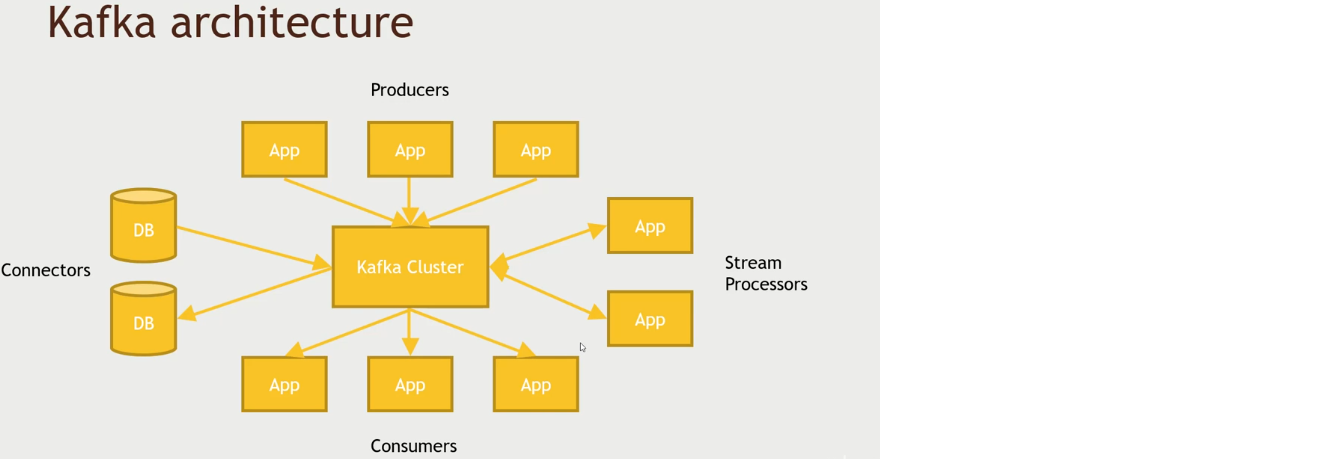

## How Kafka scales.

* Kafka itself may be distributed among many processes on many servers.
  - Will distribute the storage of stream data as well.
* Consumer may also be distributed
  - Consumers of the same group will have messages distributed amongst them
  - Consumers of different groups will get their own copy of each message
  - Consumers can process data in their own cluster/group. and you can scale up the processing of data.
  - Or consumers could habve their own group where each individual group gets its own copy.
  - The point is that you can distribute the processing of data as it comes into a consumer group or you can replicate that data to as many groups as you want.


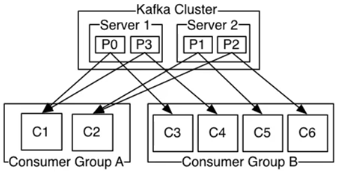

#2. Setting up Kafka, and publishing some data.

### Exercise:
* Start Kafka on our sandbox
* Set up a topic
  - Publish some data to it, and watch it get consumed
* Set up a file connector.
  - Monitor a log file and publish additions to it.

We need to start kafka (comes pre-installed)
go to ambari (127.0.0.1:8080) and log in as admin -> click on Kafka on service list -> service actions -> start.

1. Log in to PuTTY (technically is any SSH)
2. go to `cd /usr/hdp/current/kafka-broker/bin`
3. We will now create a topic in kafka to work with.
  * Note, a topic is an specific stream of data and we can publish data to that topic and consume it.
  * `./kafka-topic.sh --create --zookeeper sandbox.hortonworks.com:2181 --replication factor 1 --partitions 1 --topic fred` that means we will create a new topic named 'fred'.
  * To see all the topics created in this instance `./kafka-topics.sh --list --zookeeper sandbox.hortonworks.com:2181` 

4. Now to publish data `./kafka-console-producer.sh --broker-list sandbox.hortonworks.com:6667 --topic fred` this listens to standard input and broadcast any data it sees there onto the fred topic

5. Once the previous step starts it is now just listening for data and you can type any lines of data in the SSH. `this is a line of data`, `i am sending to the fred topic`. Now we have two lines on the fred topic on kafka, the server is sitting there and holding onto these data and wating for consumers to consume it.

6. Open a second PuTTY (another session). The previous session is dedicated to publishing to Kafka using fred and this other one is used to get the messages.

7. `cd/usr/hdp/current/kafka.broker/bin` -> `./kafka-console-consumer.sh --bootstrap-server sandbox.hortonworks.com:6667 --zookeeper localhost:2181 --topic fred --from-beginning` Now this shows you the data you placed on set. Now we have a session creating messages (producer) and one recieving messages (consumer).
  * If you write anything in the producer console, you see the data in the consumer window.

The impressive part is that this is used with MASSIVE data.

NOTE: `cntl+c` on both processes to exit

#3. Publishing web logs with Kafka

We will use a built-in kafka connector to monitor a file and publish new lines on that file to a given Kafka topic that then get's written out to some other file somewhere else. (This is closer to like log processing where you have a web server where you have some error log or access log written out continually) and you want to publish those lines into kafka where it can be agreggated and stored properly.

Kafka has a file connector we can use but we have to configure it first.

1. Pick one session `cd ..` and `cd conf` to get into the conf folder.
  * There are many connectors and properties file we can configure and use.
  * we have a connect-standalone.properties (what we will use to set up the network environment for our standalone connector server)
  * there is a connect-file-sink.properties that describes the properties of how we are going to store the contents of the stream as it comes it. (this is the consumer)
  * There is also a connect-file-source.properties that can be set up to listen to changes on a given file that we specify and publish that as a producer on a topic on the stream as well.

NOTE: Since this files are part of kafka itself, we don't really want to modify them directly, so we make copies of them.

2. `cp connect-standalone.properties ~/` the ~ is a shorcut for saying home directory -> `cp connect-file-sink.properties ~/` -> `cp connect-file-source.properties ~/` And we have copied them into our home directory.
3. Now we Cd into our home directory `cd ~` and edit them
  * We will use VI to edit them (VI is a text editor that comes with PuTTY) 
  * `vi connect-standalone.properties`
    + The main thing we need to change is the bootstrap server to specify the host that we're running on is on the correct port.
    + so we go into the 'bootstrap. servers='... linea and edit everything from the '=' sign, to edit we predd `i` in VI to insert,
    + Our host is `sandbox.hortonworks.com:6667` and we place it after the '=' (and remove everything else in that line) thats all we need for this file.
    + we press `esc` -> `:wq` to quit that file
  * `vi connect-file-sink.properties`
    - we go to the 'file=' and change it to `file=/home/maria_dev/logout.txt` This is where we want to store the results.
    - in 'topics=' you need to specify the topic we are going to listen to. In this case we will create one called 'log-test' `topics=log-test`
    - And we exit.
  * `vi connect-file-source.properties`
    - In `file=` we replace it for `file=/home/maria_dev/acess_log_small.txt` (This is a sample of an acess log from a server)
      * NOTE: most HTTP web servers are Apache at least, will write all of its access log entries into an access log folder inside the log folder of the HTTP server and rotate those logs off periodically.
    - We need to change `topic=` to `topic=log-test`
    - and we exit -> esc ->`:wq`

4. Now that everything is configured we donwload the acess log `http://media.sundog-soft.com/hadoop/acess_log_small.txt`
  * This log are actual log entries from a website

5. Before we start publishing data from that log file, lets set up a consuer to actually listen to it. So in addition to using our connector to publish and consumer this log-data information and store it into a file. We will set up another consumer to just watch it in real time.
  * To set up the consumer in PuTTY go to `cd /usr/hdp/current/kafka-broker/bin`
  * `./kafka-console-consumer.sh --bootstrap-server sandbox.hortonworks.com:6667 --topic log-test --zookeeper localhost:2181` Now we are listening to anything on the log-test topic.
   -NOTE: This happens at the same time we use our connector to both listen to changes on our acess log and publish changes to it.

6. (On the other console) We will kick off our connector that will listen to the changes on the file and publish them out
  - `cd /usr/hdp/current/kafka-broker/bin` NOTE: This is the notebook where we changed all the .properties files.
  - `./connect-standalone.sh ~/connect-standalone.properties ~/connect-file-source.properties ~/connect-file-sink.properties ` which sets up our little standalone connector. (Note, we gave it as parameters the 3 .property files edited earlier)

7. Now we can see we recieved the lines from the log in the reciever console, 
  * The connector just listens to changes on the log file and publishes them on the topic through kafka.

8. Now we open up a third PuTTY console and log in. `cd ~` and `ls` which tell us there is a logout.txt file, and we can see whats in it `less logout.txt` Here we see the data that was in the file we donwloaded.
  * In the real world maybe this would be a HDFS cluster, or a different server, etc...
  * Note, right now we have two consumer consoles.
  * If we write (in the same console) `echo "This is a new line" >> acess_log_small.txt` and we see it show in the consumer. We changed the fist file, that changed the second file and we saw that.
  * now we exit and cntl+c from all consoles

To really clean things up go to Ambari and shut down the Kafka Server















#4. Mesos explained.
It's another resource negotiatior. but it's much broader than YARN. 

NOTE: Mesos is not directly associated with Hadoop but it is useful to understand.

### What is Mesos
* Came out of Twitter - It's a system that manages resources across your data center(s)
* Not just for big data stuff - it can allocate resources for web servers, small scripts, whatever
* Meant to solve a more general problem than YARN - it's really a general container management system.

### We're going off the reservation
* Mesos isn't really part of the Hadoop ecosystem per se, but it can be used with:
  - Spark and Storm may both run on Mesos 
  - Hadoop YARN may be integrated with Mesos using Myriad
    + You don't necessarily need to partition your data center between your hadoop cluster and everything else.

### Differences between Mesos and YARN
* YARN is a monolithic scheduler - you give it a job and YARN figures out where to run.

* Mesos is a two-tiered system
 - Mesos just makes offers of resources to your application ("Framework")
 - Your framework decides whether to accept or reject them
 - You also decide your own scheduling algorithm.

* YARN is optimized for long, analytical jobs like you see in hadoop.
  * Mesos is built to handle that, as well as long-lived process (servers) and short-lived processes as well.

### How Mesos fits in

* If you're looking for an architecture you cancide all your organizations code against - not just hadoop stuff - mesos can be useful.
  * You should also look at kubernetes/Docker

* If all you are about is Spark and Storm from the hadoop-y world , Mesos is an option
  - YARN is probably better, especially if your data is HDFS
  - Spark on Mesos is limited to one executor per slave (node)

### Siloead vs resourced sharing.
We have seen this before. It basically means that you can combine your nodes to both run MESOS and YARN to use your resoruces optimally (instead of just dedicating nodes to one single technology and risk underutilization)

### When yo use Mesos:
* If your organization as a whole has chosen to use Mesos to manage it's resources
  - Then you can avoid partitioning off a Hadoop cluster by using Myriad
  - There is also a "Hadoop on Mesos" package for Cloudera that bypasses YARN entirely.

* Otherwise, probably not.

#5. Zookeeper explained

It's a system to mantaining data consistently across the cluster.

### What is zookeeper
* It basically keeps track of information that must be synchronized across your cluster.
  - Which node is the master?
  - What tasks are assigned to which workers? (if one fails where do I pick up)
  - Which workers are currently available?

* It's a tool that applications can use to recover from partial failures in your cluster.

* An integral part of HBase, High-Availability (HA) Map Reduce, Drill, Storm, Solr, and more.

### Failure modes

* Master crashes, needs to fail over to a backup
* Worker crashes, It's work needs to be redistributed.
* Network trouble - part of your cluster can't see the rest of it.

### "Primitive" operations in a distributed system

* Master election
  - Make sure only one node registers itself as a master, and holds a "lock" on that data
  - Other nodes cannot become master until that lock is released.
  - Only one node allowed to hold the lock at a time

* Crash detection
  - "Ephimeral" data on a node's abailiability automatically goes away is the node disconnects, or fails to refresh itself after some time-out period.

* Group magnament
* Metadata
  - List of outstanding tasks, task assignments.

### NOTE: ZooKeeper API is not about those primitives
* Instead they have built a more general purpose

# Me di cuenta que ya había visto esto... Me pase de carpeta. LO DE MESOS Y ZOOKEEPER YA ESTABA HECHO

#4. Flume explained

Flume is another way of streaming data into the cluster for further processing.

### What is flume
* Another way to stream data into your cluster.
* Made from the start with Hadoop in mind.
  - Built-in sinks for HDFS and Hbase
* Originally made to handle log aggregation.

It was originally built to handle log-aggregation: 
  - You have a fleet of web-servers that are fronting some massibe web site and somehow I need to get all the data from those web-servers logs into one place, on my HDFS Hadoop cluster.

NOTE: You can't directly transfer data acroos to the HDFS cluster because you need a buffer in between those two things. This is because HDFS and Hadoop don't do well with many instances connected to them at once and writing to them at once.
Also things like Log-Traffic can be "spiky" and this can mess up the system

### Anatomy and components of a Flume agent and Flow
It has a:
* source
  - Where the data is comming from
  - Can optionally have Channel Selectors:
    + so you can actually have logic attached to a source in Flume (Data that looks like X goes here, data that looks like Y goes there).
    + Can optionally have channel Interceptors that can add or reshape the data coming in before it is sent out.
* Channel
  - How the data gets transfered between the soruce and the sink (via memory or files) 
    + Memory is "good enough" most cases but files is more robust.
* Sink
  - Where the data is going (where it gets stored to)
  - Can be organized into sink groups
  - A sink can connect to only one channel
    + Channel is notified to delete a message once the sink processes it.


When you set up flume you want to connect some datasource to some place where i want to stick that data. And you can configure different types of sources and sinks that connect to different data sources or data destinations. 
  - So, you might have a Flume Source as part of a flume agent, -> that listens for web server logs being dropped in the log directories on a bunch of web servers that then -> can go through a memory channel or file channel to transfer that information -> to a sink that might be configured to actually -> write that data into some HDFS database (eg. HBASE)

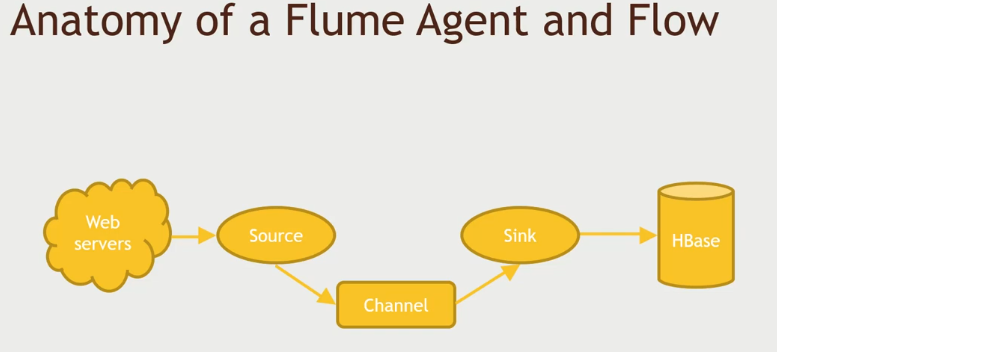

### Built-in source types
* Spooling directory
* Avro
* Kafka
* Exec
* Thrift
* Netcat
* HTTP
* Custom
* And more
Basically whatever you need to do, there is already a plug in for it.

### Built-in Sink types
* HDFS 
* HIVE
* HBase
* Avro
* Thrift
* ElasticSearch
* Kafka 
* Custom 
* More
you can write data into all those types of desitnations.

### Using AVRO, agents can connect to other agents as well.
You can set up multi-tiered designs,
this works when you might have a lot of application servers generating a log of traffic, 
1. Those logs might go the a first tier flume agents that are physically close to those servers.
2. Then you can add another layer where the first flume agents consolidate things and send the data to a third one that actually write things down.

This architecture is very scalable, and fast. Basically you divide everything and make sure no server gets overloaded.



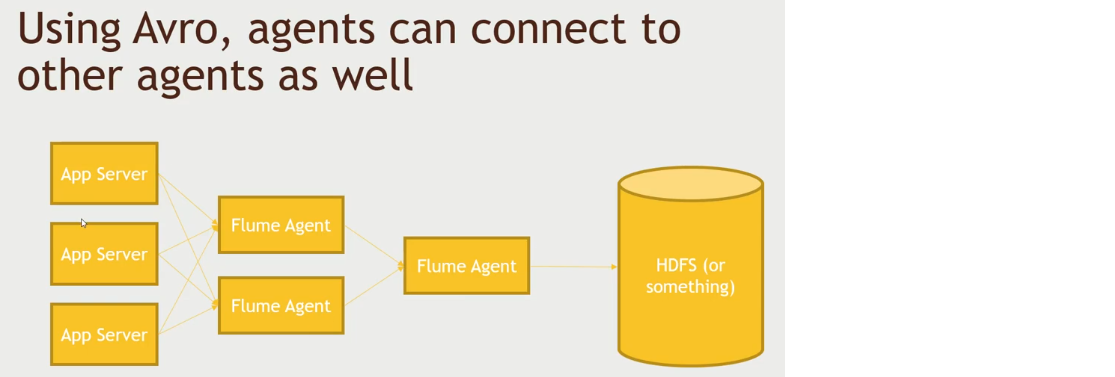

### Think of flume as a buffer the data and your cluster.
It's basically a way of smoothing out the traffic between the data coming in from your logs or whatever the source might be and whatever you are writing it into.

Example: If HDFS starts to get backed up and needs power, the closest tier (to the HDFS) might start buffering things up and if that got filled, the second tier will start doing it, and it is not untill all tiers are filled that you would actually get connection/server errors.

You want to design the flows so it's unlikely to hit the limit of the layers, but still that you don't waste power

# 5. [Activity] Set up Flume and publish logs with it. 

We will build a simple flow: 
Source (netcat) -> Channel: memory -> Sink: logger.

Then we will spool to HDFS

1. Basically set up a **Spooldir** source that monitors a directory for new files that are dropped into it.
  - To this we bolt on a **Timestamp interceptor** to actually insert a header on that data that has the current time of when the data was dropped in.

2. We push to a memory channel and go to the HDFS sink that is configured not only to write that data into HDFS but it will write it with a structure, a directory hierachy that actually has the year,month,data and 10 min interval that that data was generated whithin.


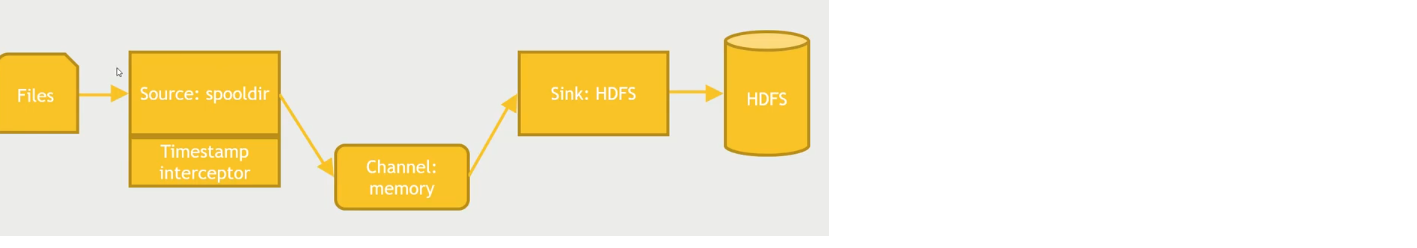

Flume comes preinstalled.

1. Start PuTTY -> log in -> We need to write a configuration file that defines the sources, channels and sinks are associated with each agent that you want in your flime setup.

2. `wget http://media.sundog-soft.com/hadoop/example.conf` -> `less example.conf` and you see the contents of an actual flume config file.
  + Basically you start off by saying what are the names that will be associated with my sources, my sinks and my channels.
  + In this case we have a single source, sink and channel.
  + First thing we do is set up a source that just listens to telnet through netcat -> it will go through a memory channel and output that just to a log through loggers sink.
  + NOTE: We call agents: A, sources:R, sinks:K just by convention.

3. Now in our configuration file:
  + where it says '#Describe/configure the source' we see our type, bind and port. -> Now netcat can listen to any socket. -> we are binding it to our localhost -> in the port 44444
  + Now we describe our sink (in '#Describe Sink') And we call it logger, that just means that it will be a logger type, which means that all it's gonna do is write information into the log from Flume and nothing else. 
    - (Note: this is not really a useful or practical sink but it's good enough for our purposes.)
  + in '#Use a channel...' The only real choices for channel type are `memory` and `file` and we decide to use memory since we don't care about persistence
  + Finally in '#Bind the source...' we just say a1 sources r1 so our r1 netcat source is going to be attached to the c1 channel. The sink is same concept.

All we are doing is setting up a netcat source, a logger sink and a memory channel that connects the two.



Now lets actually use it
1. Open up a NEW PuTTY terminal -> Start flume with that configuration `cd /usr/hdp/current/flume-server` -> and we launch a new flume agent `bin/flume-ng agent --conf conf --conf-file ~/example.conf --name a1 -Dflume.root.logger=INFO,console` So, the code means that we will open up an agent, using the configuration file in our homefolder(~)/example.conf and use the agent named a1 and that we will look at every single logger message that comes through and we will print it out to the console
  + NOTE: you can have a configuration file with more than one agent defined and use the same config for various agents.

2. Now to connect to the data we go to the first PuTTY console `telnet localhost 44444` and now we can start typing stuff and it should show up in the loger console. (The other PuTTY)
  + NOTE: Right now it's raw information data (The actual bytes) so weird things are printed.

To get out of the log we type ^] and then quit and then cntl-C


#6. Set up Flume to monitor a directory and store its data in HDFS

We will set up a Flume flow where we have a source listening to a directory, listening for file that get dropped into it. (That's a spooldir source). -> It will then transfer that again through a memory channel to a HDFS sink. We will have flume monitor a directory for new files that get dropped into it and then put those into HDFS in a certain file structure.

1. in the PuTTY console that we connected to telnet (and saw the config file) -> we make sure we are in the home directory and download a more extensive configuration file `wget media.sundog-soft.com/hadoop/flumelogs.conf`

2. Now `less flumelogs.com` to see it.
  + Our source is set up as a `spooldir` and it has a few different parameters you can set on.
    - We have to set the directory it's going to listen to,
    - We have to tell it if it has headers
    - We can create interceptors here.

So as files get created they will get timestampred and that info fill flow through the channel to our Sink. Now our Sink is an HDF sink.
  + Our sink has:
    - A type
    - A path of where the data will go
    - You can set a prefix to the files
    - We can also round values.
Basically we are creating a new subdirectory for each 10 minutes. (that's why we had the %y-%m... in the path) And the files that cames in that 10 min period will be in those folders.

Then we assign a memory channel to them and bind them. We set tje channel itself and then assign both the source and the sink to that channel. This connects everythin togheter.


In [0]:
# flumelogs.conf: A single-node Flume configuration

# Name the components on this agent
a1.sources = r1
a1.sinks = k1
a1.channels = c1

# Describe/configure the source
a1.sources.r1.type = spooldir
a1.sources.r1.spoolDir = /home/maria_dev/spool
a1.sources.r1.fileHeader = true
a1.sources.r1.interceptors = timestampInterceptor
a1.sources.r1.interceptors.timestampInterceptor.type = timestamp

# Describe the sink
a1.sinks.k1.type = hdfs
a1.sinks.k1.hdfs.path = /user/maria_dev/flume/%y-%m-%d/%H%M/%S
a1.sinks.k1.hdfs.filePrefix = events-
a1.sinks.k1.hdfs.round = true
a1.sinks.k1.hdfs.roundValue = 10
a1.sinks.k1.hdfs.roundUnit = minute

# Use a channel which buffers events in memory
a1.channels.c1.type = memory
a1.channels.c1.capacity = 1000
a1.channels.c1.transactionCapacity = 100

# Bind the source and sink to the channel
a1.sources.r1.channels = c1
a1.sinks.k1.channel = c1

### To see it in action
First we need to create the directories we will use.

1. Create the spool directory `mkdir spool` 
2. Open ambari -> log in as admin -> in the grid-> files view -> usr/maria_dev/ -> And create a new folder called flume.
3. Back in PuTTY (where we are in /usr/..../flume-server) `bin/flume-ng agent --conf conf --conf-file ~/flumelogs.conf --name a1 -Dflume.root.logger=INFO,console` (Same command from last time, but we change the config file)
4. in our other PuTTY console we write `cp access_log_small.txt spool/fred.txt` and that sends data to the spool directory, and in the other console (the flume-server) you can see it processing the data (because it was listening to changes of that folder)
5. `cd spool` `ls` Now we are in the spool directory and we can see our fred.txt.COMPLETED file, Flume adds the .COMPLETED to tell the user it's safe to get rid of the data (or anything).

EXIT FROM THE TERMINALS.